In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/test_reezocar/

/content/drive/MyDrive/test_reezocar


In [3]:
import platform
print(f"Python version : {platform.python_version()}")

Python version : 3.7.10


In [4]:
import pandas as pd
import numpy as np
from typing import Tuple, Union
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scipy
from sklearn.preprocessing import LabelEncoder,StandardScaler

In [5]:
data = pd.read_csv('data.csv')
data.head(10)

,Unnamed: 0,index,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,0,0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,1,1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2,2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,3,3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,4,4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0
5,5,5,2014-02-12,chatain,37.0,8.0,38558.0,M,master,geologie,63.46,non,1
6,6,6,2013-11-11,brun,33.0,12.0,39476.0,M,master,geologie,50.20,oui,0
7,7,7,2012-03-10,roux,31.0,10.0,42392.0,M,licence,forage,62.20,oui,0
8,8,8,2014-10-17,chatain,43.0,10.0,28625.0,M,doctorat,geologie,65.17,non,1
9,9,9,2011-06-04,chatain,28.0,11.0,32454.0,M,master,forage,66.93,non,1


In [6]:
#colonnes à supprimer
data=data.drop(["Unnamed: 0", "index"], axis=1)

I. Statistique descriptive

In [7]:
#voir la taille de nos données
data.shape

(20000, 11)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        19909 non-null  object 
 1   cheveux     19897 non-null  object 
 2   age         19909 non-null  float64
 3   exp         19904 non-null  float64
 4   salaire     19905 non-null  float64
 5   sexe        19900 non-null  object 
 6   diplome     19890 non-null  object 
 7   specialite  19907 non-null  object 
 8   note        19886 non-null  float64
 9   dispo       19894 non-null  object 
 10  embauche    20000 non-null  int64  
dtypes: float64(4), int64(1), object(6)
memory usage: 1.7+ MB


* Toutes les variables sauf embauche (variable cible) comportent des valeurs manquantes.

* embauche : La variable cible que nous souhaitons prédire doit etre convertir en catégorielle.

In [9]:
# convertion en variable categorielle
data['embauche'] = data['embauche'].astype('object')

In [10]:
data.isnull().sum()#determiner le nombre de valeurs manquantes pour chaque variable

date           91
cheveux       103
age            91
exp            96
salaire        95
sexe          100
diplome       110
specialite     93
note          114
dispo         106
embauche        0
dtype: int64

In [11]:
data.describe(include='all')

,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
count,19909,19897,19909.000000,19904.000000,19905.000000,19900,19890,19907,19886.000000,19894,20000.0
unique,1826,4,NaN,NaN,NaN,2,4,4,NaN,2,2.0
top,2012-02-03,chatain,NaN,NaN,NaN,M,master,geologie,NaN,non,0.0
freq,24,6022,NaN,NaN,NaN,11889,7513,10028,NaN,11848,17708.0
mean,NaN,NaN,35.004521,9.500352,34974.343934,NaN,NaN,NaN,75.168762,NaN,NaN
std,NaN,NaN,9.609169,3.012109,5003.099616,NaN,NaN,NaN,17.095926,NaN,NaN
min,NaN,NaN,-3.000000,-2.000000,14128.000000,NaN,NaN,NaN,8.680000,NaN,NaN
25%,NaN,NaN,29.000000,7.000000,31596.000000,NaN,NaN,NaN,63.720000,NaN,NaN
50%,NaN,NaN,35.000000,9.000000,34979.000000,NaN,NaN,NaN,75.080000,NaN,NaN
75%,NaN,NaN,41.000000,12.000000,38358.000000,NaN,NaN,NaN,86.617500,NaN,NaN


* date : colonne de type object à convertir en date et possibilité d'extraire les jours, mois et années de celle-ci.
* cheveux : 4 types de cheveux, châtain étant le plus fréquent
* age : La moyenne d'âge des candidats au poste de chercheur d'or est de 35 ans. L’âge minimum d'un des candidats est de "-3 ans" ce qui constitue une valeur aberrante.
* exp : L'expérience moyenne est d'environ 9 ans. exp min est égale à -2 cela n'est pas normale.
* salaire : Le salaire moyen est d'environ 35000
* sexe : Présence masculine majoritaire
* diplôme : 4 types de diplôme, les candidats ont majoritairement un master
* spécialité : 4 types de spécialités, la majorité est spécialisée en géologie
* note : La note moyenne est de 75. Cependant la notation est sur 100, pourtant un candidat a eu la note de 143 d'où valeur aberrante.
* dispo : 2 types de disponibilités, la majorité des candidats ne sont pas disponibles immédiatement.
* la majorité des candidats sont ne sont pas retenus soit 17708/20000 soit 0.8854

In [12]:
def display_countplot(df: pd.DataFrame,col_x: str,titre: str,hue: Union[None,str]=None):
  #Affichage du graphe permettant de dénombrer la parts de candidats de chaque catégorie d'une variable catégorielle
  
  temp = df.copy()
  nb_rows = temp.shape[0]
  
  if col_x=='embauche' or hue=='embauche':
      temp['embauche'] = np.where(temp['embauche']==0,'non','oui')
  
  fig = plt.figure(figsize=(11,6))
  
  # plot grouped bar chart
  if hue is None:
      splot = sns.countplot(temp[col_x])
  else:
      splot = sns.countplot(temp[col_x],hue=temp[hue])
  splot.set_title(titre,fontsize=20)

  #Affichage des proportions au dessus des barplots
  for p in splot.patches:
      splot.annotate(format((p.get_height()/nb_rows), '.4f'),
                      (p.get_x()+ p.get_width()/ 2., p.get_height()),
                      ha = 'center',
                      va = 'center',
                      xytext = (0, 7),
                      textcoords = 'offset points')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


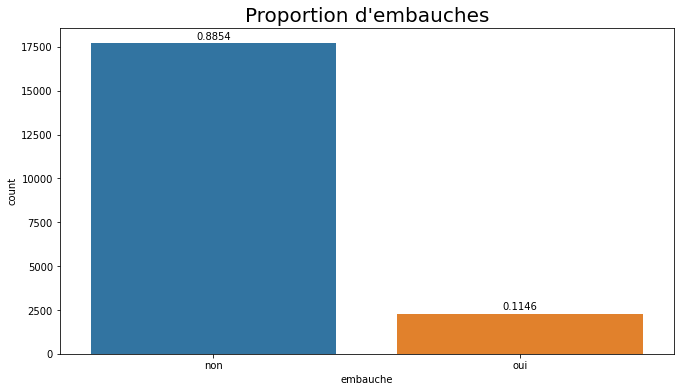

In [13]:
display_countplot(data,'embauche',"Proportion d'embauches")

**Le jeu de donnée n'est pas équilibré il va falloir en tenir compte dans la construction du modèle.**

In [14]:
def display_boxplot(df: pd.DataFrame, numerical_cols: list):

  #Affichage des boxplot des variables numériques
  plt.figure(figsize=(20,8))
  i = 0
  for columns_ in numerical_cols:
      i = i+1
      plt.subplot(2, 4, i)
      box = sns.boxplot(x=df[columns_], data=df)
      #box.set_title(str(columns_),fontsize=15)

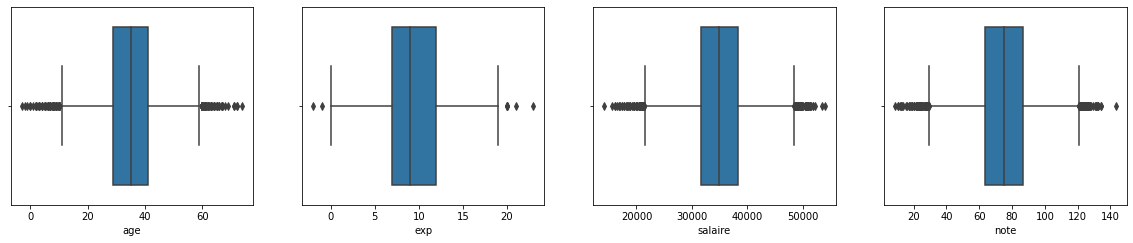

In [15]:
num_df = data.select_dtypes(include="float64")
num_cols = list(num_df.columns)
display_boxplot(num_df,num_cols)

Il y a pas mal de valeurs aberrantes

In [16]:
def pair_plot(df: pd.DataFrame, numerical_cols: list, target: Union[None,str]=None):
  #Affichage des corrélations deux à deux des variables numériques différencié par la variable embauche
    plt.figure(figsize=(10,10))
    if target is not None:
        numerical_cols.append(target)
        sns.pairplot(df[numerical_cols],height = 2, hue=target)
        numerical_cols.remove(target)
    else:
        sns.pairplot(df[numerical_cols],height = 2)

<Figure size 720x720 with 0 Axes>

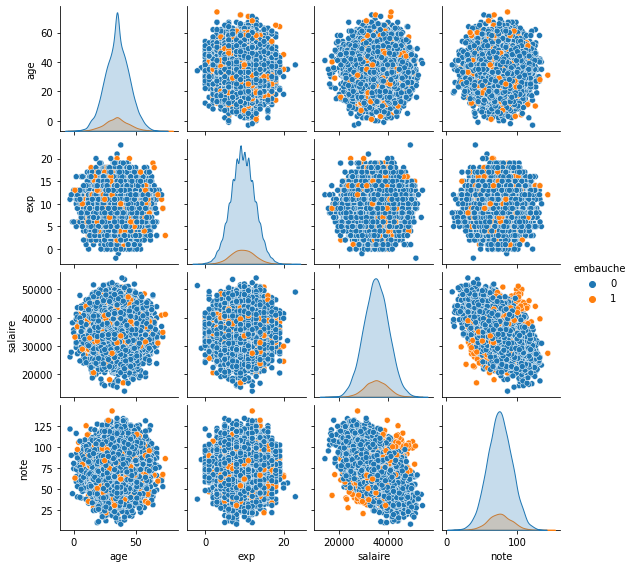

In [17]:
pair_plot(data,num_cols,target='embauche')

On s'attendait a obtenir une corrélation positive entre l'âge et l'expérience ou entre le salaire et l'expérience ou encore entre les notes et l'expérience mais on remarque qu'il n'y a pas de corrélation entre ces variables. On observe une légère corrélation négative entre les notes et le salaire.

In [18]:
def extraire_features_dates(df: pd.DataFrame):
  #Extraction du jour, mois et année de la date
  df['jour']=(df['date'].apply(lambda x: x.day)).astype('object')
  df['mois']=(df['date'].apply(lambda x: x.month)).astype('object')
  df['annee']=(df['date'].apply(lambda x: x.year)).astype('object')
  
  return df
  
def transformation(df: pd.DataFrame):
  #Toute transformation de données ou ajouts de features 
  df['date'] = pd.to_datetime(df['date'])
  df = extraire_features_dates(df)
  niveau_diplome = {'bac':0,'licence':1,'master':2,'doctorat':4} # On utilise se codage car bac<licence<master<doctorat 
  df['niveau_diplome'] = df['diplome'].map(niveau_diplome)
  
  return df

In [19]:
data_trans = transformation(data)

In [20]:
data_trans.shape

(20000, 15)

**VALEURS ABERRANTES** </br>
Les valeurs aberrantes respectent les conditions suivantes : </br>
1) Candidats ayant une expérience supérieure à leurs âges </br> 2) Candidats ayant une note inférieure à 0 ou supérieur à 100 </br> 3) Candidats ayant une expérience inférieure à 0 </br> 4) Candidats ayant un niveau de diplôme supérieur ou égale au bac tandis qu'ils ont au plus 14 ans </br>

In [21]:
#Liste des conditions ordonnées en fonction du listing fait ci-dessus
conditions = [(data_trans.exp > data_trans.age),
              (np.logical_or(data_trans.note < 0,data_trans.note > 100)),
              (data_trans.exp < 0),
             (np.logical_and(data_trans.niveau_diplome >=0 , data_trans.age <=14))]

In [22]:
#Afficher le nombre de candidats concernés par chacune des conditions ainsi que le nombre d'embauchés parmis eux
i = 0
for cond in conditions:
    i = i+1
    index_to_delete = data_trans[cond].index
    nb_pers = len(data_trans[cond])
    try:
        nb_embauche = data_trans[cond].embauche.value_counts()[1]
        print(f"{nb_pers} candidats sont dans le cas n°{i} et {nb_embauche} embauchés")
    except:
        print(f"{nb_pers} candidats sont dans le cas n°{i} et 0 embauchés")
    # Suppression des candidats respectant ces conditions
    data_trans.drop(index_to_delete,axis=0,inplace=True)
#data_trans.drop(['diplome'],axis=1,inplace=True)

104 candidats sont dans le cas n°1 et 12 embauchés
1452 candidats sont dans le cas n°2 et 136 embauchés
2 candidats sont dans le cas n°3 et 0 embauchés
234 candidats sont dans le cas n°4 et 23 embauchés


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [23]:
data_trans.shape

(18208, 15)

**VALEURS MANQUANTES**</br>
Pour ce faire, nous allons utiliser des fonctions personnalisées ainsi que la librairie missngno qui permet d'analyser les valeurs manquantes. </br>

Diagramme en bâton : Ce graphe nous montre le nombre de valeurs manquantes par colonnes. On remarque toutefois qu'il n'y a pas beaucoup de valeurs manquantes.
Matrice de corrélation : On aperçoit aucune corrélation quant à la présence ou non de valeurs manquantes. Seuls les variables mois, année et jour sont corrélées car elles ont été construite à partir de la même variable : Date

In [24]:
def missingValues(df: pd.DataFrame):
  null_df = pd.DataFrame((df.isnull().sum().sort_values(ascending = False)),columns=['null_values'])
  null_df = null_df[null_df.null_values>0]
  plt.figure(figsize=(20,5))
  bar = sns.barplot(null_df.index,null_df.null_values)
  bar.set_title("Nombre de valeurs manquantes par colonnes",fontsize=16)
  
  return list(null_df.index)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


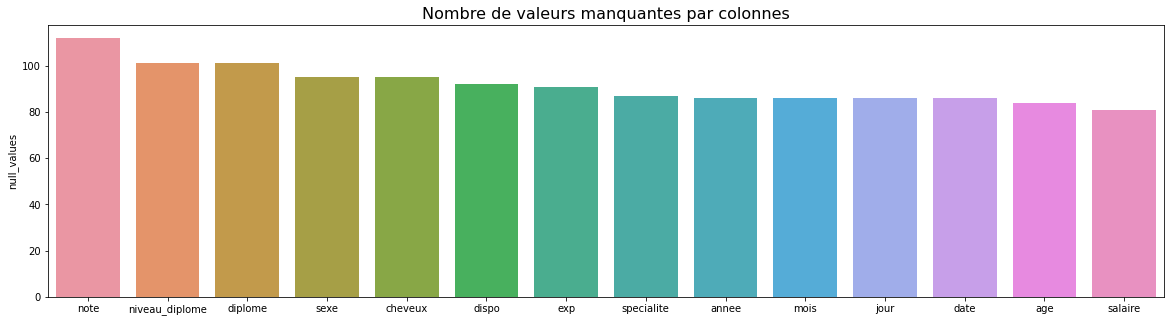

In [25]:
#data_trans=data_trans.drop(["diplome"], axis = 1)
nulls_cols = missingValues(data_trans)

In [26]:
import missingno as msno

**Corrélation entre les valeurs manquantes et la variable cible ?**

In [27]:
def analyse_missing_data(df: pd.DataFrame, null_cols: list, target: str):
  for col in null_cols:
      if df[df[col].isnull()][target].value_counts()[0] == 0 or df[df[col].isnull()][target].value_counts()[1] == 0: #Vérifier la présence unique de candidats embauchés ou non dès lors qu'une variable contenant des valeurs manquantes apparait
          print(f"Les valeurs manquantes de la colonne {col} ont peut-être un impact sur la variable {target}")
      else:
          print(f"Les valeurs manquantes de la colonne {col} n'influent pas sur la variable : {target}")

Nous allons vérifier qu'aucune valeurs manquantes n'explique la variable cible

In [28]:
analyse_missing_data(data,null_cols=nulls_cols,target='embauche')

Les valeurs manquantes de la colonne note n'influent pas sur la variable : embauche
Les valeurs manquantes de la colonne niveau_diplome n'influent pas sur la variable : embauche
Les valeurs manquantes de la colonne diplome n'influent pas sur la variable : embauche
Les valeurs manquantes de la colonne sexe n'influent pas sur la variable : embauche
Les valeurs manquantes de la colonne cheveux n'influent pas sur la variable : embauche
Les valeurs manquantes de la colonne dispo n'influent pas sur la variable : embauche
Les valeurs manquantes de la colonne exp n'influent pas sur la variable : embauche
Les valeurs manquantes de la colonne specialite n'influent pas sur la variable : embauche
Les valeurs manquantes de la colonne annee n'influent pas sur la variable : embauche
Les valeurs manquantes de la colonne mois n'influent pas sur la variable : embauche
Les valeurs manquantes de la colonne jour n'influent pas sur la variable : embauche
Les valeurs manquantes de la colonne date n'influent 

Nous allons supprimer les valeurs manquantes car elles sont reparties de manière aleatoire puisqu'elles ne sont pas corrélées avec la variable cible.

In [29]:
data_trans = data_trans.dropna(axis=0)

In [30]:
print(data_trans.shape)
list(data_trans)

(17303, 15)


['date',
 'cheveux',
 'age',
 'exp',
 'salaire',
 'sexe',
 'diplome',
 'specialite',
 'note',
 'dispo',
 'embauche',
 'jour',
 'mois',
 'annee',
 'niveau_diplome']

In [31]:
def compute_IQR_find_outliers(df: pd.DataFrame,cols: list):

  #Calcul de l'interval interquartile et suppression des valeurs extreme

  Q1 = df[cols].quantile(0.25)
  Q3 = df[cols].quantile(0.75)
  IQR = Q3 - Q1
  IQR_min = Q1 - 1.5 * IQR
  IQR_max = Q3 + 1.5 * IQR
  
  df_out = df[~((df[cols] < IQR_min) | (df[cols] > IQR_max)).any(axis=1)]
  
  return df_out

In [32]:
data_trans = compute_IQR_find_outliers(data_trans,num_cols)
#data = compute_IQR_find_outliers(data_trans,num_cols)

In [33]:
# 291 valeurs étaient des valeurs extrêmes 
data_trans.shape

(17005, 15)

Malgrés la suppression de certaines observations on a presque les memes proportions des deux classes (embauche/non embauche) dans le dataset.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


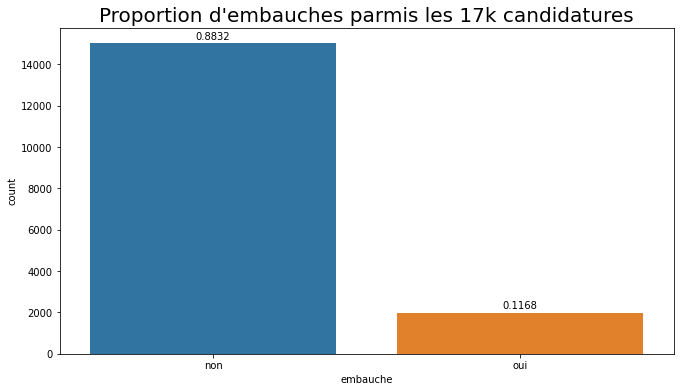

In [34]:
display_countplot(data_trans,'embauche',"Proportion d'embauches parmis les 17k candidatures")

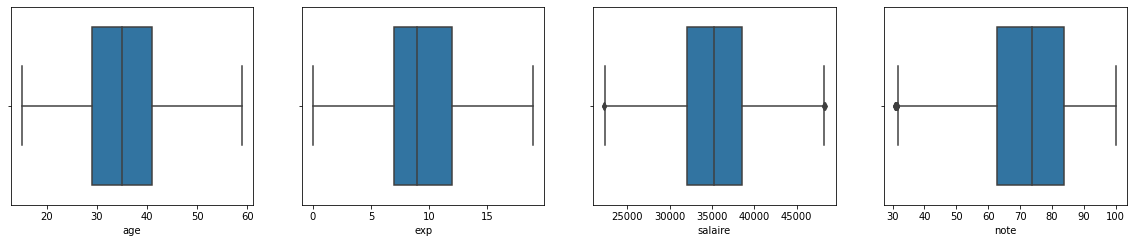

In [35]:
#Les boites à moustaches sont plus "propres" c'est à dire qu'elles n'ont plus de valeurs extrêmes
display_boxplot(data_trans,num_cols)

In [36]:
# Afin d'y voir plus clair dans nos graphes, je partage en trois quantiles les variables note et salaire qui possède de nombreuses valeurs uniques
data_trans['note_cut']=pd.qcut(data_trans['note'],q=3,labels=['Low','Mid','High'])
data_trans['salaire_cut']=pd.qcut(data_trans['salaire'],q=3,labels=['Low','Mid','High'])

In [37]:
# Description des groupes note
data_trans.groupby('note_cut')['note'].describe()

,count,mean,std,min,25%,50%,75%,max
note_cut,,,,,,,,
Low,5670.0,56.430189,8.068224,30.79,51.57,58.290,62.88,66.95
Mid,5670.0,73.645102,3.770192,66.96,70.43,73.685,76.91,80.19
High,5665.0,88.598489,5.510774,80.20,83.85,87.990,93.03,100.00


In [38]:
# Description des groupes salaire
data_trans.groupby('salaire_cut')['salaire'].describe()

,count,mean,std,min,25%,50%,75%,max
salaire_cut,,,,,,,,
Low,5669.0,30088.026460,2406.776921,22225.0,28666.00,30632.0,32027.00,33205.0
Mid,5668.0,35252.960303,1179.133639,33206.0,34246.75,35245.0,36257.25,37357.0
High,5668.0,40449.381616,2400.135708,37358.0,38516.75,39912.0,41877.50,48300.0


In [39]:
def display_boxplot_differenciate(df: pd.DataFrame,numerical_cols: list,target: str):
  temp = df.copy()
  plt.figure(figsize=(18,6))
  i = 0
  if target=='embauche':
      temp['embauche'] = np.where(temp['embauche']==0,'non','oui')
  for columns_ in numerical_cols:
      i = i+1
      plt.subplot(1, 4, i)
      box = sns.boxplot(x=temp[target], y=temp[columns_], data=temp)
      box.set_title(f"{columns_} vs {target}",fontsize=15)

Boites à moustaches : Il est compliqué de voir des tendances se former à partir de ces graphes. Cela prouve que nos variables numériques ne permettent pas en elles-mêmes de différencier un candidat embauché d'un non embauché. Cependant, nous avons remarqué quelques légères différences grâces aux variables d'expérience ou de salaire. Celles-ci nous montrent que les candidats embauchés ont une très légère tendance à avoir des valeurs moins élevées que les candidats non embauchés. Mais aucune conclusion ne peut être faite à ce niveau.

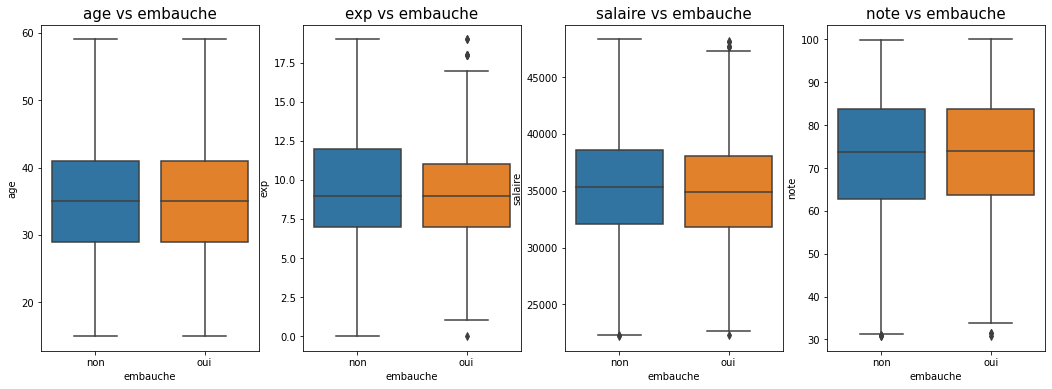

In [40]:
display_boxplot_differenciate(data_trans,num_cols,"embauche")

In [41]:
def display_barplot_differenciate(df: pd.DataFrame, numerical_cols: list, target: str):
  temp = df.copy()
  plt.figure(figsize=(35,8))
  i = 0
  temp.embauche  = temp.embauche.astype("int")
  for columns_ in numerical_cols:
      i = i+1
      if ("age") in numerical_cols:
          plt.subplot(1, 1, i)
      else:
          plt.subplot(2, 3, i)
      df_grouped = temp.groupby(columns_)[target].mean().reset_index()
      df_grouped = df_grouped[df_grouped[target]>0]
      bar = sns.barplot(x=df_grouped[columns_], y=df_grouped[target], data=df_grouped)
      bar.set_title(f"{columns_} vs {target}",fontsize=15)

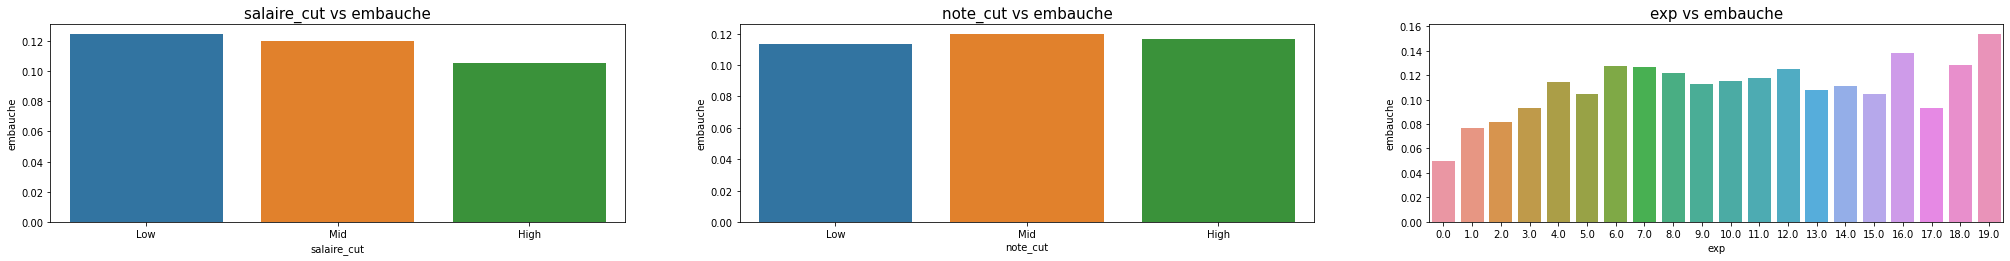

In [42]:
cols = ["salaire_cut","note_cut","exp"]
display_barplot_differenciate(data_trans,numerical_cols=cols,target="embauche")

Les tendances sont :</br> Les candidats demandant un salaire de 30K en moyenne ; </br>Ceux possédant des notes tournant autour d’environ 73/100 </br> ceux ayant le plus d'expérience sont le plus embauchés.

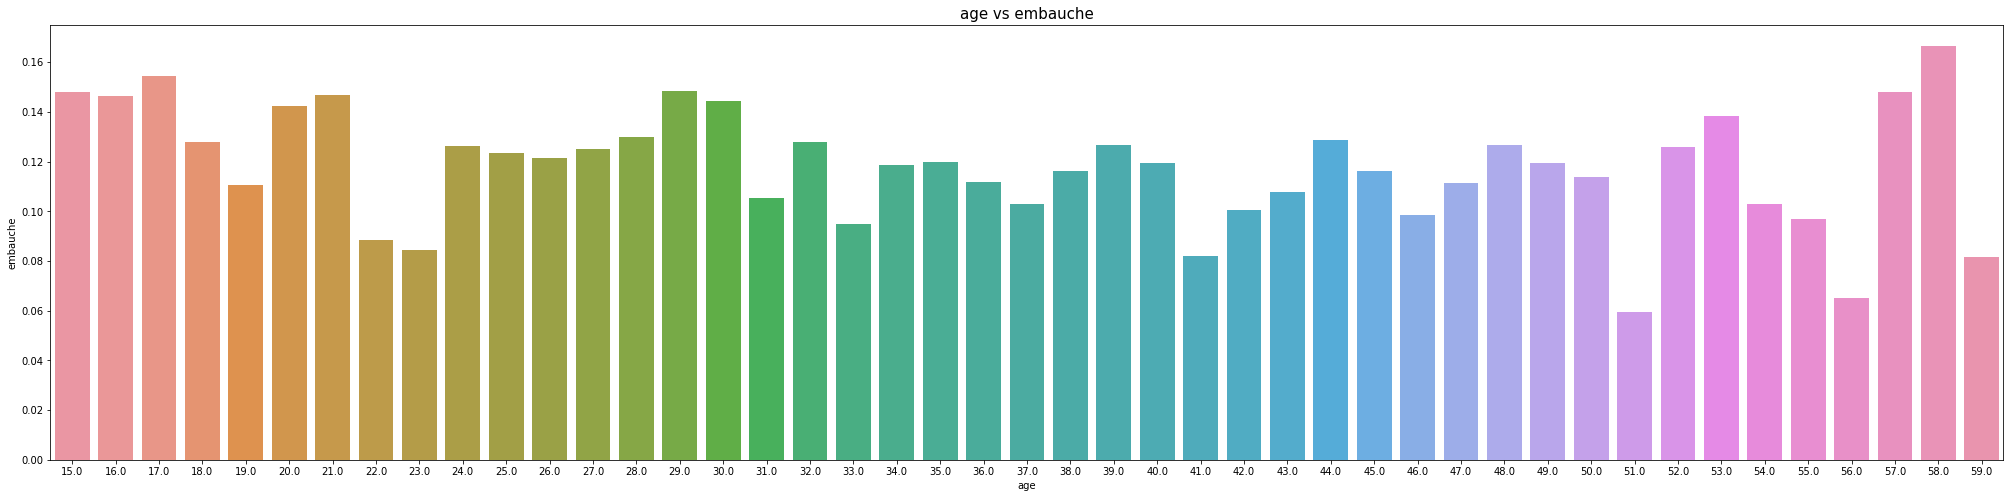

In [43]:
cols = ["age"]
display_barplot_differenciate(data_trans,cols,"embauche")

En ce qui concerne l'âge, cela varie beaucoup trop pour en déduire une quelconque tendance.

In [44]:
cat_df = data_trans.select_dtypes(include="object")

Le test de corrélation de cramer V nous montre l'intensité dans la relation entre deux variables catégorielles. </br> Remarques :

Nous observons une très forte relation entre la disponibilité et le diplôme. Les candidats ayants un master ou un doctorat sont plus souvent disponibles immédiatement que les candidats ayant une licence ou un bac. Ce qui fait sens.
Il y a une forte relation entre la disponibilité et la spécialité. Les archéologues ou les détectives sont le plus souvent disponibles.

In [45]:
def cramersv_corr(x: pd.Series, y: pd.Series):
  #Calcule de la corrélation de cramers V entre deux variables catégorielles
  confusion_matrix = pd.crosstab(x,y)
  chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
  n = confusion_matrix.sum().sum()
  phi2 = chi2/n
  r,k = confusion_matrix.shape
  phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
  rcorr = r-((r-1)**2)/(n-1)
  kcorr = k-((k-1)**2)/(n-1)
  return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def cramer_matrix(categoricals: pd.DataFrame) -> pd.DataFrame:
  #Fonction permettant de construire une matrice à partir de du calcul des coefs de correlation de cramers V
  categ_col_name = categoricals.columns
  n_var = len(categ_col_name)
  correlation_matrix = pd.DataFrame(np.ones((n_var, n_var)),
                                    index=categ_col_name,
                                    columns=categ_col_name)
  for name1, name2 in itertools.combinations(categ_col_name, 2):
      if name1 == name2:
          cramer_coef = 1
      else:
          cramer_coef = cramersv_corr(categoricals[name1],
                                                categoricals[name2])
      correlation_matrix.loc[name1, name2] = cramer_coef
      correlation_matrix.loc[name2, name1] = cramer_coef
  return correlation_matrix

In [46]:
coor_mat = cramer_matrix(cat_df)
cm = sns.light_palette("blue", as_cmap=True)
coor_mat.style.background_gradient(cmap=cm)

,cheveux,sexe,diplome,specialite,dispo,embauche,jour,mois,annee
cheveux,1.000000,0.286933,0.327452,0.085118,0.117426,0.045566,0.013540,0.000000,0.008135
sexe,0.286933,1.000000,0.002174,0.360725,0.103615,0.000000,0.000000,0.011693,0.005603
diplome,0.327452,0.002174,1.000000,0.066014,0.446066,0.048425,0.021434,0.000000,0.000000
specialite,0.085118,0.360725,0.066014,1.000000,0.372503,0.086116,0.011844,0.000000,0.000000
dispo,0.117426,0.103615,0.446066,0.372503,1.000000,0.000000,0.016000,0.000000,0.018925
embauche,0.045566,0.000000,0.048425,0.086116,0.000000,1.000000,0.022505,0.016767,0.028637
jour,0.013540,0.000000,0.021434,0.011844,0.016000,0.022505,1.000000,0.039128,0.020120
mois,0.000000,0.011693,0.000000,0.000000,0.000000,0.016767,0.039128,1.000000,0.000000
annee,0.008135,0.005603,0.000000,0.000000,0.018925,0.028637,0.020120,0.000000,1.000000


**Y a-t-il une dépendance statistiquement significative entre la spécialité et le sexe ?**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


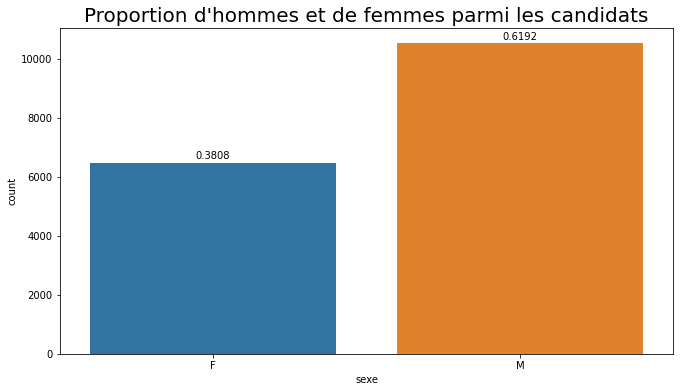

In [47]:
display_countplot(data_trans,'sexe',"Proportion d'hommes et de femmes parmi les candidats")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


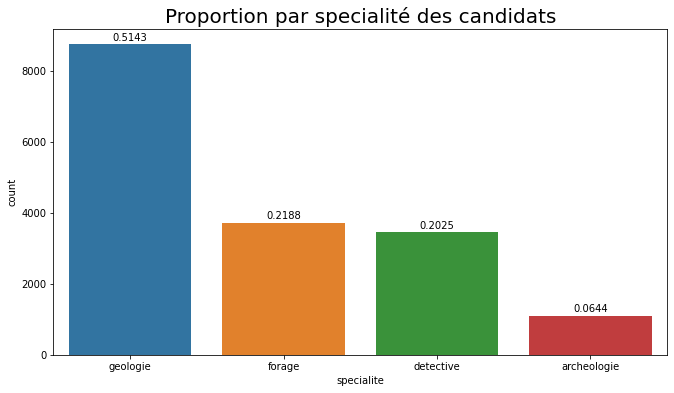

In [48]:
#La specialité la plus représentée parmi les candidats est la géologie
display_countplot(data_trans,'specialite',"Proportion par specialité des candidats")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


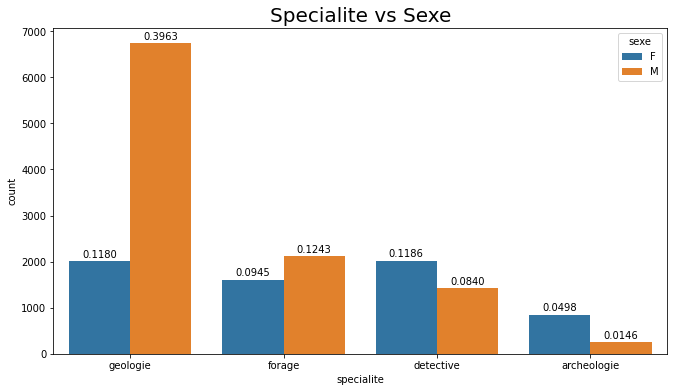

In [49]:
#Les specialités géologie et forage sont le plus représentées par des hommes tandis que détective et archeologie par des femmes
display_countplot(data_trans,'specialite',"Specialite vs Sexe",hue="sexe")

le coefficient de cramer montre une forte relation entre la specialité et le sexe

In [50]:
cramersv_corr(cat_df['specialite'],cat_df['sexe'])

0.36072492673362083

**Y a-t-il une dépendance statistiquement significative entre La couleur de cheveux et le salaire demandé?**</br>
Observons le salaire demandé par les candidats et leurs couleurs de cheveux. Nous remarquons que la différence est légère, les candidats aux cheveux châtain auraient des prétentions salariale plus élevées tandis que les candidats aux cheveux roux auraient attentes moindres. Cependant cela peut s'expliquer par la faible representativité des candidats aux cheveux roux parmi les candidats

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Cheveux vs salaire')

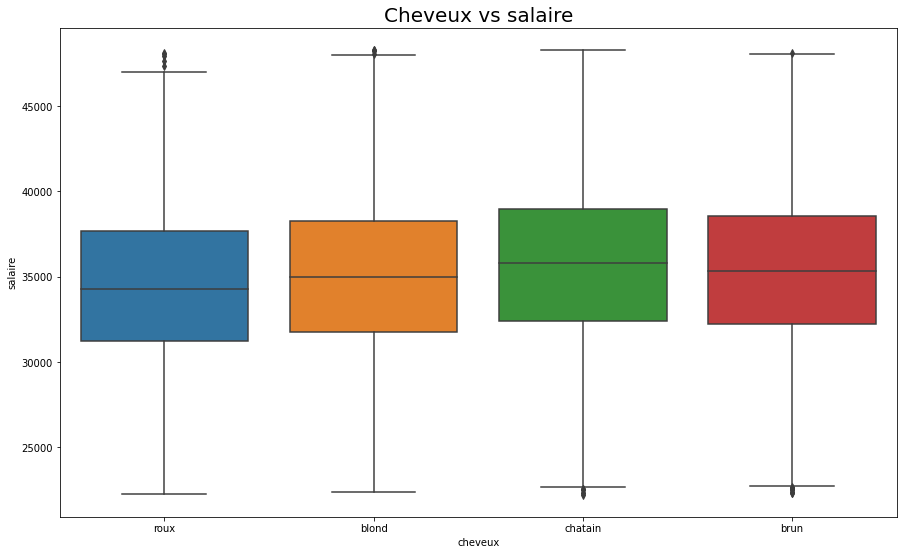

In [51]:
plt.figure(figsize=(15,9))
box = sns.boxplot("cheveux","salaire",data=data_trans)
box.set_title('Cheveux vs salaire',fontsize=20)

Si nous affichons leurs distributions nous remarquons que la différence est très légère

In [52]:
data.groupby("cheveux")["salaire"].agg([np.mean, np.std, np.median, np.min, np.max])

,mean,std,median,amin,amax
cheveux,,,,,
blond,34970.645519,4890.181300,34961.0,14128.0,52287.0
brun,35406.901896,4775.129300,35351.0,18250.0,51861.0
chatain,35827.428007,4867.761740,35866.0,17047.0,53977.0
roux,34511.147636,4822.392416,34358.5,19521.0,49926.0


Le tau de kendall permet de vérifier la corrélation entre des variables où il existe une relation d'ordre entre les modalités . </br> Comme le confirme ce coefficient, il n'y a pas de lien statistiquement significatif entre la couleur des cheveux et le salaire.

In [53]:
def kendalltau_corr(x, y):
  x_arr=np.array(pd.DataFrame(x))
  y_arr=np.array(pd.DataFrame(y))
  corr,_=scipy.stats.kendalltau(x_arr,y_arr)
  return corr

In [54]:
kendalltau_corr(data_trans["cheveux"],data_trans["salaire"])

0.016916671622820793

**Y a-t-il une dépendance statistiquement significative entre le nombre d’années d’expérience et la note à l’exercice ?**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Expérience vs note')

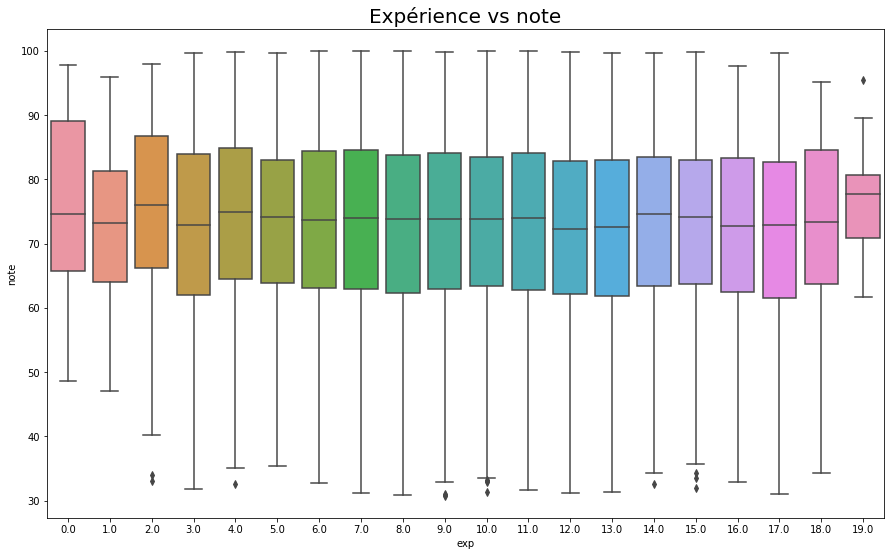

In [55]:
plt.figure(figsize=(15,9))
box = sns.boxplot("exp","note",data=data_trans)
box.set_title('Expérience vs note',fontsize=20)

L'expérience et la note permettent de classer les candidats (1er, 2ème, ..) on peut donc utiliser le coefficient de Kendall pour determiner l'existance de correlation.

In [56]:
kendalltau_corr(data_trans["exp"],data_trans["note"])

-0.011759219022684122

Le tau de kendall nous montre qu'il n'y a pas de lien statistiquement significatif entre l'expérience et la note.

**Preparation du dataframe pour l'application d'un modèle de machine learning</br>**
* Suppression des variables non utiles pour la prédiction</br>
* Encodage des variables à valeurs binaires</br>
* Conversion des variables categorielles en variables indicatrices (dummy variable).

In [57]:
cols_to_delete = ['date','jour','note_cut','salaire_cut','mois','annee', 'niveau_diplome']
df_final = data_trans.drop(cols_to_delete,axis=1)

In [58]:
df_final.head()

,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
4,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0
5,chatain,37.0,8.0,38558.0,M,master,geologie,63.46,non,1


In [59]:
cols = ["cheveux","sexe","specialite","dispo","diplome"]
le = LabelEncoder()
cols_to_dummies = list()
for col in cols:
  if len(set(df_final[col]))>2:
    cols_to_dummies.append(col)
  else:
    df_final[col] = le.fit_transform(df_final[col])

In [60]:
df_final = pd.get_dummies(data=df_final,columns=cols_to_dummies)

In [61]:
cols_to_scale = ["age","exp","salaire","note"]
scaler = StandardScaler()
df_final[cols_to_scale] = scaler.fit_transform(df_final[cols_to_scale])

In [62]:
df_final.head()

,age,exp,salaire,sexe,note,dispo,embauche,cheveux_blond,cheveux_brun,cheveux_chatain,cheveux_roux,specialite_archeologie,specialite_detective,specialite_forage,specialite_geologie,diplome_bac,diplome_doctorat,diplome_licence,diplome_master
0,-1.154160,-0.163480,-1.795269,0,1.672353,0,0,0,0,0,1,0,0,0,1,0,0,1,0
1,-0.030547,1.169520,0.615993,1,-0.623962,0,0,1,0,0,0,0,0,1,0,0,0,1,0
2,-0.704714,1.169520,-0.011916,1,0.388021,0,0,1,0,0,0,0,0,0,1,0,0,1,0
4,-0.030547,-1.163229,-1.428158,0,0.623735,0,0,0,0,0,1,0,1,0,0,0,0,1,0
5,0.194176,-0.496729,0.699176,1,-0.651612,0,1,0,0,1,0,0,0,0,1,0,0,0,1


In [63]:
temp = df_final.copy()
temp.embauche = temp.embauche.astype("int")
plt.figure(figsize=(10,10))
tc = temp.corr()
cm = sns.light_palette("blue", as_cmap=True)
tc.style.background_gradient(cmap=cm)

,age,exp,salaire,sexe,note,dispo,embauche,cheveux_blond,cheveux_brun,cheveux_chatain,cheveux_roux,specialite_archeologie,specialite_detective,specialite_forage,specialite_geologie,diplome_bac,diplome_doctorat,diplome_licence,diplome_master
age,1.000000,-0.004646,0.001962,-0.001574,-0.009193,-0.015267,-0.018105,-0.008295,-0.006364,0.011224,0.005518,-0.013963,-0.006762,0.006255,0.007120,-0.007999,-0.000049,0.025105,-0.019769
exp,-0.004646,1.000000,0.009738,0.003204,-0.017152,-0.004612,0.000565,-0.001794,-0.004223,0.008416,-0.003626,0.015237,-0.003584,-0.006891,0.001099,-0.002086,0.001672,0.001132,-0.000744
salaire,0.001962,0.009738,1.000000,0.083539,-0.384382,0.227454,-0.025820,-0.042125,0.011186,0.068293,-0.057324,0.079022,0.095572,0.042084,-0.150470,0.217432,-0.199522,0.142850,-0.169701
sexe,-0.001574,0.003204,0.083539,1.000000,-0.209716,0.104021,0.004370,0.162274,-0.015037,-0.247107,0.152346,-0.211697,-0.212336,-0.055700,0.320780,0.008447,0.009258,-0.004917,-0.006609
note,-0.009193,-0.017152,-0.384382,-0.209716,1.000000,0.303413,0.013224,0.000439,0.012815,0.017810,-0.048224,0.070741,0.093464,0.019761,-0.126242,-0.339039,0.263045,-0.170132,0.241440
dispo,-0.015267,-0.004612,0.227454,0.104021,0.303413,1.000000,0.007182,-0.049834,0.008316,0.094257,-0.080966,0.183742,0.250019,0.055102,-0.336857,-0.254792,0.291885,-0.233675,0.229589
embauche,-0.018105,0.000565,-0.025820,0.004370,0.013224,0.007182,1.000000,0.010327,0.013604,0.006426,-0.047283,0.082824,-0.014770,-0.035772,0.000793,-0.045846,-0.005711,0.002667,0.032414
cheveux_blond,-0.008295,-0.001794,-0.042125,0.162274,0.000439,-0.049834,0.010327,1.000000,-0.437690,-0.427927,-0.215880,-0.053324,-0.039012,-0.003412,0.060380,0.123796,-0.174074,0.179101,-0.157602
cheveux_brun,-0.006364,-0.004223,0.011186,-0.015037,0.012815,0.008316,0.013604,-0.437690,1.000000,-0.427808,-0.215820,0.002969,0.007540,-0.002041,-0.005833,-0.120848,-0.077246,0.032862,0.098037
cheveux_chatain,0.011224,0.008416,0.068293,-0.247107,0.017810,0.094257,0.006426,-0.427927,-0.427808,1.000000,-0.211006,0.080948,0.062676,0.024213,-0.110181,-0.218362,0.322139,-0.234338,0.186391


<Figure size 720x720 with 0 Axes>

A ce stade nous pouvons émettre l'hypothèse que les variables qui pourraient avoir une influence sur les prédictions de la variable cible sont :

La spécialité,</br>
Le diplome,</br>
Le salaire.

In [64]:
df_final.shape

(17005, 19)

In [65]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17005 entries, 0 to 19999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     17005 non-null  float64
 1   exp                     17005 non-null  float64
 2   salaire                 17005 non-null  float64
 3   sexe                    17005 non-null  int64  
 4   note                    17005 non-null  float64
 5   dispo                   17005 non-null  int64  
 6   embauche                17005 non-null  object 
 7   cheveux_blond           17005 non-null  uint8  
 8   cheveux_brun            17005 non-null  uint8  
 9   cheveux_chatain         17005 non-null  uint8  
 10  cheveux_roux            17005 non-null  uint8  
 11  specialite_archeologie  17005 non-null  uint8  
 12  specialite_detective    17005 non-null  uint8  
 13  specialite_forage       17005 non-null  uint8  
 14  specialite_geologie     17005 non-null

**MACHINE LEARNING**

In [66]:
# Librairie des modèles machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [67]:
#separer les données en train set (80%) and test set (20%)
X = df_final.drop(['embauche'],axis=1)
y = df_final["embauche"].astype('int64')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
y.value_counts()

0    15018
1     1987
Name: embauche, dtype: int64

**Recherche d'hyperparamètres**

In [69]:
lr_params = {'class_weight': ['balanced'], 
             'solver': ['lbfgs', 'saga'], 
             'max_iter':[10, 100, 1000]}
              
rf_params ={'criterion': ['entropy'],
            'max_depth': [8, 10, None],
            'min_samples_leaf': [7, 9],
            'min_samples_split': [30, 60],
            'class_weight' : ['balanced']}
             
xgb_params = {
    'booster' : ['gbtree', 'gblinear'],
    #'class_weight' : ['balanced'],
    'random_state':[19],
    'scale_pos_weight':[7.55]}

svm_params = {
    'kernel':['linear', 'rbf', 'poly'], 
    'class_weight' : ['balanced'],
    'C':[0.1, 0.5, 1]}

In [70]:
print("Best model logistic regression")
clf = GridSearchCV(LogisticRegression(), lr_params, n_jobs=-1, cv=10, scoring='f1_weighted')
clf.fit(X_train, y_train)
print('score',clf.score(X_train, y_train))
print(clf.best_params_)

Best model logistic regression
score 0.6216618827921687
{'class_weight': 'balanced', 'max_iter': 10, 'solver': 'saga'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [71]:
print("Best model random forest")
clf = GridSearchCV(RandomForestClassifier(), rf_params, n_jobs=-1, cv=10, scoring='f1_weighted')
clf.fit(X_train, y_train)
print('score',clf.score(X_train, y_train))
print(clf.best_params_)

Best model random forest
score 0.9222210538494691
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 7, 'min_samples_split': 30}


In [72]:
print("Best model XGBOOST")
clf = GridSearchCV(xgb.XGBClassifier(), xgb_params, n_jobs=-1, cv=10, scoring='f1_weighted')
clf.fit(X_train, y_train)
print('score',clf.score(X_train, y_train))
print(clf.best_params_)

Best model XGBOOST
score 0.8148454899084469
{'booster': 'gbtree', 'random_state': 19, 'scale_pos_weight': 7.55}


In [74]:
#Attention le temps d'execution de ce bloc est d'environ 10 min
print("Best model SVM")
svc = svm.SVC()
clf = GridSearchCV(svc, svm_params, n_jobs=-1, cv=10, scoring='f1_weighted')
clf.fit(X_train, y_train)
print('score',clf.score(X_train, y_train))
print(clf.best_params_)

Best model SVM
score 0.8628016820343978
{'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf'}


**Construction de modèles à partir des hyperparamètres obtenus et test sur le test set**</br>
Metriques utilisées et justification :
* accuracy : correspond au nombre d'observation classé correctement par le modèle dans les deux classes
* precision : pour une classe donnée il nous donne la proportion d'observation bien classé par rapport au nombre d'observation predire dans cette classe.
* recall : Pour une classe quelconque il nous donne la proportion d'observations bien classé par rapport au nombre d'observations réel de cette classe.
* f1-score : moyennne harmonique de la precision et du recall, plus la precision et le recall sont elevés, le f1-score est élévé.

In [75]:
lr_params = {'class_weight': 'balanced', 'max_iter': 10, 'solver': 'saga'}
rf_params = {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 7, 'min_samples_split': 30}
xgb_params = {'booster': 'gbtree', 'random_state': 19, 'scale_pos_weight': 7.55}
svm_params = {'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf'}

In [76]:
from sklearn.svm import SVC
models = {
          'lr':LogisticRegression(**lr_params),
          'rf':RandomForestClassifier(**rf_params), 
          'xgb':xgb.XGBClassifier(**xgb_params),
          'svm':SVC(**svm_params)
          }

model_abrv = {
              'lr':'Logistic Regression',
              'rf':'Random Forest Classifier', 
              'xgb':'XGB Classifier',  
              'svm':'SVM Classifier'
              }

In [77]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, model='clf', save=True):
  """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a seaborn heatmap. 
  Saves confusion matrix file to jpg file."""
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names, 
  )
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  try:
      heatmap = sns.heatmap(df_cm, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)
  except ValueError:
      raise ValueError("Confusion matrix values must be integers.")
      
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  # fix for mpl bug that cuts off top/bottom of seaborn viz
  b, t = plt.ylim() 
  b += 0.5 
  t -= 0.5 
  plt.ylim(b, t) 
  if save == True:
      plt.savefig('tuned_' + model_abrv[model] + '_confusion_matrix.jpg')
  plt.show()

In [78]:
def model(clf, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, models=models, save=False, print_stat=True, inc_train=False, cv=False):
  """Trains models and outputs score metrics. Takes an identifier, list of models, and split dataset as inputs and has options for saving model, 
  printing confusion matrix and classification report and getting cross-validated 5 fold accuracy."""
  clf_model = models[clf]
  clf_model.fit(X_train, y_train)
  y_pred = clf_model.predict(X_test)
  if print_stat == True:
      clf_report = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).T
      clf_report.to_csv('tuned_' + model_abrv[clf] + '_classification_report.csv')
      print(model_abrv[clf])
      print('\nTest Stats\n', classification_report(y_test,y_pred))
      print(f"accuracy = {accuracy_score(y_test, y_pred)}")
      print_confusion_matrix(confusion_matrix(y_test, y_pred), unique_labels(y_test, y_pred), model=clf)
      if inc_train == True:
          print(model_abrv[clf])
          print('\nTrain Stats\n', classification_report(y_train,clf_model.predict(X_train)))
          print_confusion_matrix(confusion_matrix(y_train, clf_model.predict(X_train)), unique_labels(y_test, y_pred), model=clf)
  if cv == True:
      print(model_abrv[clf] + ' CV Accuracy:',  
            np.mean(cross_val_score(clf_model, X_train, y_train, cv=10, scoring='accuracy')))
  if save == True:
      return clf_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic Regression

Test Stats
               precision    recall  f1-score   support

           0       0.91      0.54      0.68      3004
           1       0.14      0.57      0.23       397

    accuracy                           0.55      3401
   macro avg       0.52      0.56      0.45      3401
weighted avg       0.82      0.55      0.63      3401

accuracy = 0.5471920023522493


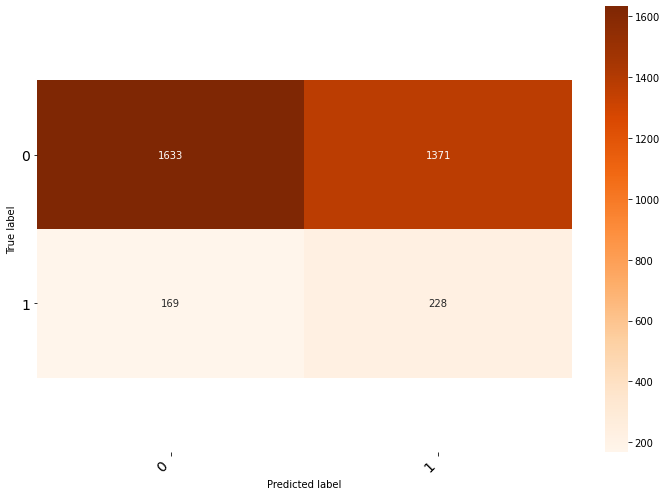

Random Forest Classifier

Test Stats
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      3004
           1       0.51      0.68      0.58       397

    accuracy                           0.89      3401
   macro avg       0.73      0.80      0.76      3401
weighted avg       0.90      0.89      0.89      3401

accuracy = 0.8876800940899735


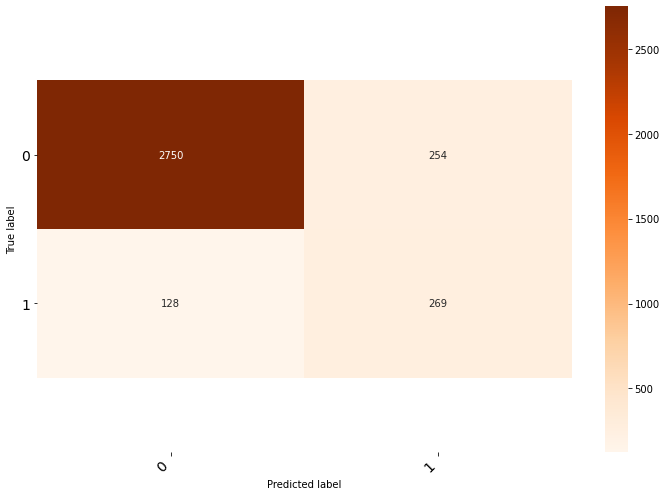

XGB Classifier

Test Stats
               precision    recall  f1-score   support

           0       0.96      0.77      0.86      3004
           1       0.31      0.78      0.45       397

    accuracy                           0.77      3401
   macro avg       0.64      0.78      0.65      3401
weighted avg       0.89      0.77      0.81      3401

accuracy = 0.773301970008821


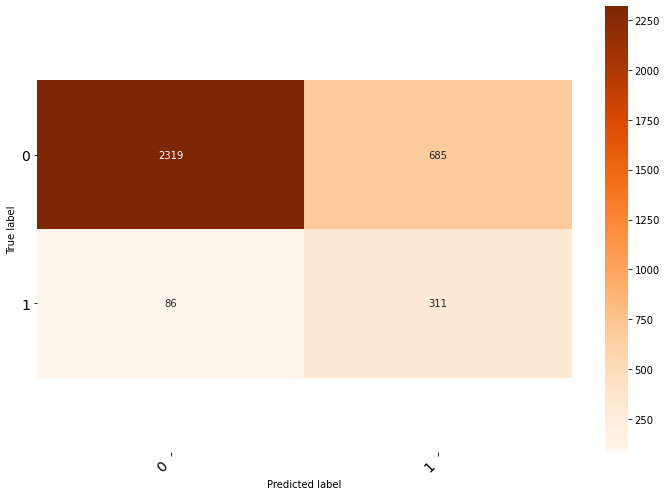

SVM Classifier

Test Stats
               precision    recall  f1-score   support

           0       0.96      0.84      0.89      3004
           1       0.37      0.74      0.50       397

    accuracy                           0.82      3401
   macro avg       0.67      0.79      0.70      3401
weighted avg       0.89      0.82      0.85      3401

accuracy = 0.8244633931196707


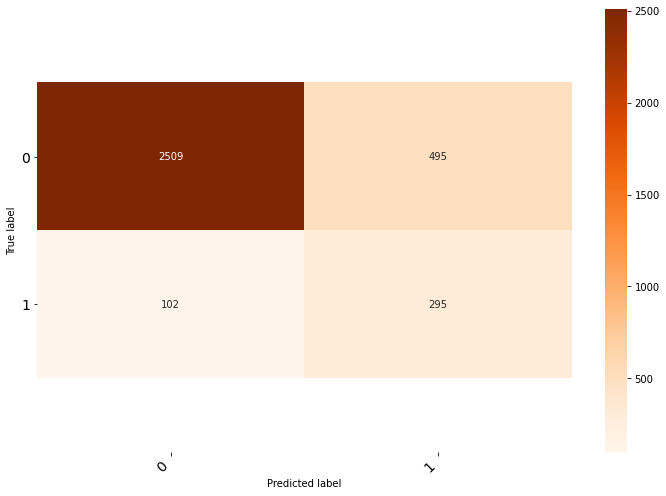

In [79]:
for key in models.keys():
    model(key, inc_train=False)

**BUT : Determiner si un candidat sera embauché du coup la classe qui nous interesse est la classe "1" : classe embauché**. </br> Pour le choix definitive de notre modèle nous allons regarder principalement la metrique f1-score pour la classe "1" puisqu'elle tient compte de la precision et du recall.</br> Parmi les modèles que nous avons realiser celui qui a le f1-score le plus élévé est "RandomForest" avec f1-score=0.58.</br>
* rappel classe embauché = 0.68
* précision classe embauché = 0.51
* f1-score classe embauché = 0.58

# le meilleur modèle est "RandomForest"

**Importance des variables**

No handles with labels found to put in legend.


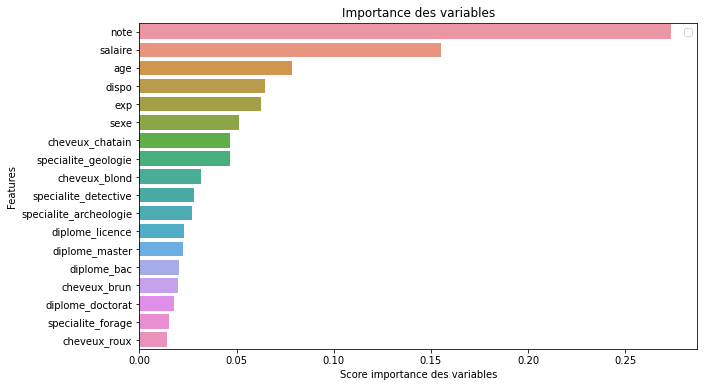

In [80]:
clf_final=RandomForestClassifier(**rf_params)
model = clf_final.fit(X_train, y_train)
feature_imp = pd.Series(model.feature_importances_,index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Score importance des variables')
plt.ylabel('Features')
plt.title("Importance des variables")
plt.legend()
plt.show()

les variables note, salaire, age, dispo et exp sont celles qui discrimine le plus nos classes.

**Piste d'améliorations :**</br>
* Utiliser des méthodes de réechantillonage dans le but d'equilibrer le data set. </br> 
 * Undersampling : Supprimer des individus de la classe majoritaire * . </br>
 * Oversampling : Dupliquer des individus de la classe minoritaire *
* Passer plus de temps sur la recherche de paramètres, qui pourraient réajuster les prédictions de la classe minoritaire pour le modèle Random Forest
* Essayer un modèle avec les reseaux de neuronnes.